<h1>DAVE's INSIDES</h1>
Must run to work

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset

# Load the MNIST dataset
from torchvision.datasets import MNIST


# Create the neural network
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #Fully Connected
        # self.fc1 = torch.nn.Linear(28*28, 128)
        # self.fc2 = torch.nn.Linear(128, 256)
        # self.fc3 = torch.nn.Linear(256, 128)
        # self.fc4 = torch.nn.Linear(128, 10)

        
        self.cv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2),
            
            torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),

            torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2)
        )

        self.fc = torch.nn.Sequential(
            torch.nn.Linear(144, 144),
            torch.nn.ReLU(),
            torch.nn.Linear(144, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 10)
        )

        
    

    def forward(self, x):
        # x = torch.nn.functional.relu(self.fc1(x))
        # x = torch.nn.functional.relu(self.fc2(x))
        # x = torch.nn.functional.relu(self.fc3(x))
        # x = self.fc4(x)
        x = self.cv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        # x = self.cv2(x)
        return x
     


<h1>Teach DAVE (OPTIONAL)</h1>
Do not run if you have a slow computer

cuda
True


c:\Users\ethan\.conda\envs\cudaPytorch\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
c:\Users\ethan\.conda\envs\cudaPytorch\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
c:\Users\ethan\.conda\envs\cudaPytorch\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
c:\Users\ethan\.conda\envs\cudaPytorch\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


(120000, 1, 28, 28)
SUCCESS


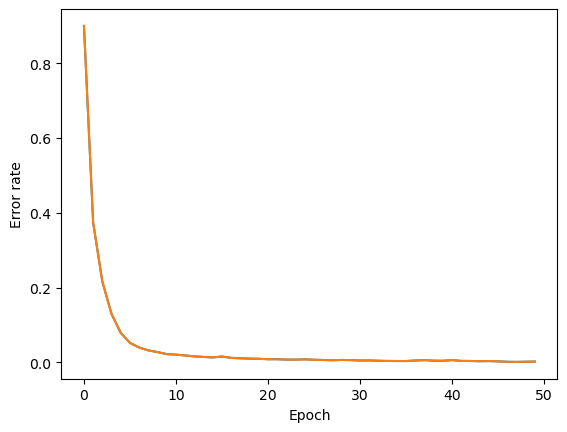

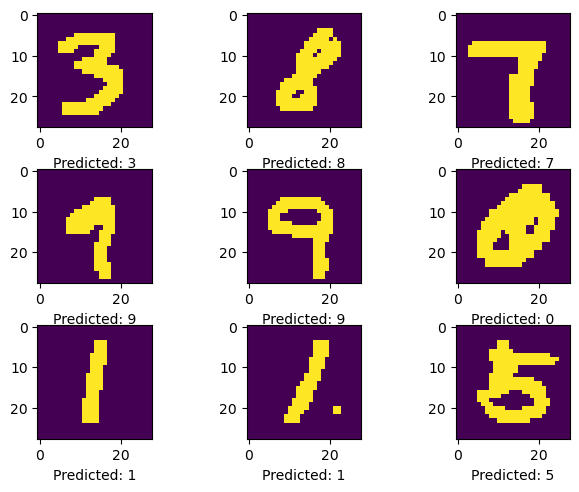

In [2]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Force CPU
forceCPU = False
if forceCPU:
    device=torch.device("cpu")
print(device)

dataset = MNIST(root='.', download=True)

print(torch.cuda.is_available())

# Preprocess the data
#Lin
# X_train = dataset.train_data.numpy().reshape((-1, 28*28)) / 255.0
# X_test = dataset.test_data.numpy().reshape((-1, 28*28)) / 255.0

#Conv
X_train = dataset.train_data.numpy().reshape(-1,1,28,28) / 255.0
X_test = dataset.test_data.numpy().reshape(-1,1,28,28) / 255.0

y_train = dataset.train_labels.numpy()
y_test = dataset.test_labels.numpy()

#Image augmentation doubles data points
X_trainNoAA = np.ceil(X_train)
X_testNoAA = np.ceil(X_test)

X_train = np.concatenate((X_train, X_trainNoAA))
X_test = np.concatenate((X_test, X_testNoAA))
y_train = np.concatenate((y_train, y_train))
y_test = np.concatenate((y_test, y_test))

del X_testNoAA, X_trainNoAA
####

print(X_train.shape)


# Convert the labels to one-hot encoded vectors
y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

cudaxTrain = torch.tensor(X_train, dtype=torch.float, device=device)
cudayTrain = torch.tensor(y_train, dtype=torch.float, device=device)

cudaxVal = torch.tensor(X_test, dtype=torch.float, device=device)
cudayVal = torch.tensor(y_test, dtype=torch.float, device=device)

BATCHSIZE = 10000
dataset = TensorDataset(cudaxTrain,cudayTrain)
dataloader = DataLoader(dataset=dataset, batch_size=BATCHSIZE, shuffle=True)




model = Net()
model.to(device)
model(cudaxTrain)

print("SUCCESS")

# Define the loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
numEpochs = 50
history = np.zeros(shape=(numEpochs), dtype=float)
errorRate = np.zeros(shape=(numEpochs), dtype=float)
indexRange = torch.arange(cudayVal.shape[0])
indexRangeTrain = torch.arange(cudayTrain.shape[0])
# Train the model
for epoch in range(numEpochs):

    for idx, (x_batch,y_batch) in enumerate(dataloader):
        # Forward pass
        outputs = model(x_batch)
        loss = loss_fn(outputs, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #/////////////////////

    #Forward pass
    # outputs = model(torch.tensor(X_train, dtype=float))
    # loss = loss_fn(outputs, y_batch)

    # # Backward pass
    # optimizer.zero_grad()
    # loss.backward()
    # optimizer.step()

    #///////////////////////

    #Calculate error rate
    valPred = model(cudaxVal)
    valPred = torch.argmax(valPred,dim=1)
    correct = cudayVal[indexRange,valPred]
    numCorrect = 1-(torch.sum(correct).item() / cudayVal.shape[0])

    errorRate[epoch] = numCorrect


    #Calculate error rate on training set

    valPred = model(cudaxTrain)
    valPred = torch.argmax(valPred,dim=1)
    correct = cudayTrain[indexRangeTrain,valPred]
    numCorrect = 1-(torch.sum(correct).item() / cudayTrain.shape[0])
    
    history[epoch] = numCorrect

    #clear memory
    del valPred, correct, numCorrect

    print("Epoch:"+str(epoch), end="\r")

torch.save(model.state_dict(), "MNISTtrainedModel.pt")

#Plot the error rate
plt.plot(history)
plt.plot(errorRate)
plt.xlabel('Epoch')
plt.ylabel('Error rate')
plt.show()

model.eval()
fig, ax = plt.subplots(3,3)
ax = ax.flatten()
fig.tight_layout(pad=0.9)

X_test = X_test.reshape(-1,28,28)
xValPred = model(cudaxVal)
xValPred = xValPred.cpu().detach().numpy()
for x in range(70000, 70009):
    test = X_test[x]
    ax[x-70000].imshow(test)
    ax[x-70000].set_xlabel("Predicted: " + str(np.argmax(xValPred[x])))



<h1>Load DAVE if you don't want to train one yourself!</h1>
If you want to train or modify, rename MODELTOUSE

In [3]:
MODELTOUSE = "DAVE2.pt"
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
dataset = MNIST(root='.', download=True)
model = Net()
model.load_state_dict(torch.load(MODELTOUSE, map_location=device))
model = model.eval()
model.to(device=device)


X_train = dataset.train_data.numpy().reshape(-1,1,28,28) / 255.0
X_test = dataset.test_data.numpy().reshape(-1,1,28,28) / 255.0



y_train = dataset.train_labels.numpy()
y_test = dataset.test_labels.numpy()

y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

xTestTensor = torch.tensor(X_test, dtype=torch.float32, device=device)
yTestTensor = torch.tensor(y_test, dtype=torch.float32, device=device)

xTestPredictions = torch.argmax(model(xTestTensor),dim=1)
# numCorrect = 0

# for x in xTestPredictions:
#     if y_test[x,xTestPredictions[x]] == 1:
#         numCorrect+=1
# print(numCorrect/yTestTensor.size(0))
# print(numCorrect)

numCorrect2 = torch.sum(yTestTensor[torch.arange(yTestTensor.size(0)), xTestPredictions], dtype=torch.long)
print(f"Error rate ({yTestTensor.size(0)} Samples): {((yTestTensor.size(0)-numCorrect2.item())*100/yTestTensor.size(0))}%")





RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

<h1>Draw your own number and let <abbr title="Deeply Accurate Vision Expert">DAVE</abbr> guess your number</h1>
<p>Draw by holding down the left mouse button</p>
<p>To reset, right click.</p>
<p>When your number is complete, press enter!</p>

In [2]:
import pygame
from tkinter import *
from tkinter import messagebox
import numpy as np
Tk().wm_withdraw()

class Grid:
    def __init__(self) -> None:
        self.cells = []
        for j in range(0,28):
            row = []
            for i in range(0,28):
                row.append(Cell([i*20, j*20]))
            self.cells.append(row)
    def draw(self):
        for row in self.cells:
            for cell in row:
                cell.draw()
    def drawOn(self, pos):
        x = pos[0]
        y = pos[1]

        #Outside boundries
        if y >= 28*20 or y < 0:
            return
        if x >= 28*20 or x < 0:
            return
        row = y//20
        column = x//20

        #Change cell over
        self.cells[row][column].drawOn()
        
        #Slightly add white to outer cells

        # if row+1 < 28:
        #     self.cells[row+1][column].bleedOn(255)

        # if row-1 >= 0:
        #     self.cells[row-1][column].bleedOn(255)

        # #Horizontal
        # if column+1 < 28:
        #         self.cells[row][column+1].bleedOn(255)
        # if column-1 >= 0:
        #         self.cells[row][column-1].bleedOn(255)

    def toNumpy(self):
        arr = np.zeros(shape=(28,28),dtype=float)
        for j in range(28):
            for i in range(28):
                v,_,_a = self.cells[j][i].value
                arr[j,i] = v/255
        return arr
    def clear(self):
        for row in self.cells:
            for cell in row:
                cell.clear()

class Cell:
    def __init__(self, pos):
        self.pos=pos
        self.width=20
        self.value = BLACK

    def draw(self):
        pygame.draw.rect(screen,self.value,[self.pos[0], self.pos[1], self.width, self.width])


    def drawOn(self):
        self.value = WHITE
    def bleedOn(self, amount):
        amount /=30
        if self.value == WHITE:
            return
        r,g,b = self.value
        r += amount
        g += amount
        b += amount
        r = min(255.0, r)
        g = min(255.0, g)
        b = min(255.0, b)
        self.value = (r,g,b)
    def clear(self):
        self.value = BLACK

# Define some colors
BLACK = (0, 0, 0)
WHITE = (255, 255, 255)

# Call this function so the Pygame library can initialize itself
pygame.init()
 
# Create an 560x560 sized screen
screen = pygame.display.set_mode([560, 560])
 
# This sets the name of the window
pygame.display.set_caption('Number Drawer for DAVE')
 
clock = pygame.time.Clock()
 

 
# Load and set up graphics.
grid = Grid()


done = False
 
while not done:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            done = True
        if event.type == pygame.MOUSEBUTTONDOWN:
            if event.button == 3:
                grid.clear()
        if event.type == pygame.KEYDOWN:
            if event.key == 13: #ENTER Key pressed
                #Run through NN
                npDigit = grid.toNumpy()
                digitTensor = torch.tensor(npDigit.reshape(1, 1, 28, 28), device=device, dtype=torch.float32)
                modelPred = torch.argmax(model(digitTensor)[0]).item()
                
                messagebox.showinfo("MODEL Predictions: You drew a..", str(modelPred))


                

                
    if pygame.mouse.get_pressed()[0]:
        pos=pygame.mouse.get_pos()
        grid.drawOn(pos)
        grid.drawOn([pos[0] + 20, pos[1]])
        grid.drawOn([pos[0] - 20, pos[1]])
        grid.drawOn([pos[0], pos[1]+20])
        grid.drawOn([pos[0], pos[1]-20])
    grid.draw()

 
    pygame.display.flip()
 
    clock.tick(60)
 
pygame.quit()



pygame 2.1.2 (SDL 2.0.18, Python 3.8.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


NameError: name 'device' is not defined

In [5]:
torch.cuda.empty_cache()